In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imresize, imrotate
%matplotlib inline
import keras

root_dir = os.path.abspath('..')

Using TensorFlow backend.


In [2]:
def fetch_data(base_dir,num_subjects):
    '''Load in simulated data and motion files.'''
    subject_list = os.listdir((os.path.join(base_dir)))
    subject_list = [item for item in subject_list if item.startswith('.') == False] #Filter .DS_STORE
    counter = 0
    X = np.zeros((108*num_subjects,72,86,55))
    y = np.zeros(108*num_subjects)
    X_subject = np.zeros((72,86,55,108))
    y_subject = np.zeros(108)
    for subject_index, subject_number in enumerate(subject_list):
        data_path = os.path.join(base_dir,subject_number,'data.nii.gz')
        if os.path.isfile(data_path):
            data_header = nib.load(data_path)
            X_subject = data_header.get_data()
            for i in range(108):
                motion = np.loadtxt(os.path.join(base_dir,subject_number,'motion/motion'+str(i)+'.txt'))
                y_subject[i] = create_labels(motion)
            start_index = counter*108
            end_index = (counter+1)*108
            X[start_index:end_index,:] = np.moveaxis(X_subject,3,0)
            y[start_index:end_index] = y_subject
            counter += 1
    return X,y

def create_labels(motion, translation_threshold=1, rotation_threshold = 1):
    '''Take a POSSUM motion file and decide whether it contains signficant intra-volume movement.'''
    max_motion = np.max(motion[:,1:],axis=0)
    min_motion = np.min(motion[:,1:],axis=0)
    diff_motion = np.abs(max_motion-min_motion)
    diff_motion[:3] = diff_motion[:3]*1000
    diff_motion[3:] = np.rad2deg(diff_motion[3:])
    if np.any( diff_motion[:3] > translation_threshold):
        return 1
    elif np.any(diff_motion[3:] > rotation_threshold):
        return 1
    else:
        return 0
    
def pad_image(image,pad_max):
    if pad_max == 0:
        return image
    else:
        pad_width = np.array([[pad_max,pad_max],[pad_max,pad_max]])-[image.shape,image.shape]
        pad_width=np.transpose(pad_width)
        pad_width[:,0] = np.floor(pad_width[:,0]/2)
        pad_width[:,1] = np.ceil(pad_width[:,1]/2)
        return np.lib.pad(image,pad_width,'constant',constant_values=(0))
    
def preprocess_data_planar(X,target_height=299,target_width=299,is_training=False,\
                           flip=False,rotate_z=False,base_slice=36,sample_more_slices=True,\
                           pad_images=False,crop_image=False,rescale=False):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([base_slice,base_slice,base_slice]) #Planes to slice
    if pad_images == True:
        pad_max = np.max(X.shape[2:]) #Width to pad images to
    else:
        pad_max = 0
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[2]
    num_slices = X.shape[3]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))
    if is_training == True:
        for i in range(num_volumes):
            vol = np.copy(np.squeeze(X[i,:]))
            #Flip
            if flip == True:
                if np.random.uniform() > 0.5:
                    vol = np.fliplr(vol)
                if np.random.uniform() > 0.5:
                    vol = np.flip(vol,2)
            #Rotate about z
            if rotate_z == True:
                angle = np.random.randint(-20,20)
                for slice_num in range(num_slices):
                    vol[:,:,slice_num] = imrotate(vol[:,:,slice_num],angle,interp='bilinear')
            #Sample different slice in plane
            if sample_more_slices == True:
                slices_new = slices + np.random.randint(-5,5)
            else:
                slices_new = slices
            #Crop
            if crop_image == True:
                image_ratio = width / height
                target_image_ratio = target_width / target_height
                crop_vertically = image_ratio < target_image_ratio
                crop_width = width if crop_vertically else int(height * target_image_ratio)
                crop_height = int(width / target_image_ratio) if crop_vertically else height

                # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
                # between 1.0 and 1.0 + `max_zoom`.
                max_zoom = 0.8
                resize_factor = np.random.rand() * max_zoom + 1.0
                crop_width = int(crop_width / resize_factor)
                crop_height = int(crop_height / resize_factor)

                # Next, we can select a random location on the image for this bounding box.
                x0 = np.random.randint(0, width - crop_width)
                y0 = np.random.randint(0, height - crop_height)
                x1 = x0 + crop_width
                y1 = y0 + crop_height
            else:
                x0=0;y0=0;x1=width;y1=height
            for j in range(3):
                if (j == 0):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(vol[slices_new[j],y0:y1, x0:x1],pad_max),(target_width,target_height))
                if (j == 1):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(vol[slices_new[j],y0:y1, x0:x1],pad_max),(target_width,target_height))
                if (j == 2):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(vol[slices_new[j],y0:y1, x0:x1],pad_max),(target_width,target_height))     
                    
    else:
        pad_max = np.max(X.shape[2:]) #Always pad for testing
        for i in range(num_volumes):
            for j in range(3):
                if (j == 0):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
                if (j == 1):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
                if (j == 2):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))     
   
    if rescale == True:
        X_preprocessed = X_preprocessed.astype(np.float32)
        X_preprocessed/= 255
        X_preprocessed -= 0.5
        X_preprocessed *= 2.
    return X_preprocessed

def preprocess_data_coronal(X,target_height=299,target_width=299, base_slice=36,rescale=False,):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([base_slice,base_slice,base_slice]) #Planes to slice
    pad_max = np.max([X.shape[1],X.shape[3]]) #Width to pad images to
    
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[3]
    num_slices = X.shape[2]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))

    for i in range(num_volumes):
        for j in range(3):
            if (j == 0):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 1):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 2):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))     
   
    if rescale == True:
        X_preprocessed = X_preprocessed.astype(np.float32)
        X_preprocessed/= 255
        X_preprocessed -= 0.5
        X_preprocessed *= 2.
    return X_preprocessed

In [3]:
from sklearn.model_selection import train_test_split

X, y = fetch_data(os.path.join(root_dir,'data/sims'),8)

num_vols = 108
num_train = 6
num_test = 2
slices_to_extract = [20,36,52]

X_train = np.zeros((num_vols*num_train*len(slices_to_extract),299,299,3))
X_test = np.zeros((num_vols*num_test*len(slices_to_extract),299,299,3))
y_train = np.zeros((num_vols*num_train*len(slices_to_extract)))
y_test = np.zeros((num_vols*num_test*len(slices_to_extract)))

for slice_num, slice_indx in enumerate(slices_to_extract):
    start_indx_train = slice_num * num_vols*num_train
    end_indx_train = (slice_num+1) * num_vols*num_train
    start_indx_test = slice_num * num_vols*num_test
    end_indx_test = (slice_num+1) * num_vols*num_test
    X_preprocessed = preprocess_data_coronal(X,base_slice=slice_indx)

    X_train[start_indx_train:end_indx_train,:] = X_preprocessed[:num_vols*num_train]
    X_test[start_indx_test:end_indx_test,:] = X_preprocessed[num_vols*num_train:]
    y_train[start_indx_train:end_indx_train]= y[:num_vols*num_train]
    y_test[start_indx_test:end_indx_test]=y[num_vols*num_train:]

#Clear memory
del X,y, X_preprocessed

In [ ]:
plt.imshow(X_train[1400,:,:,0])

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.utils import to_categorical

train_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-6,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.0,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=preprocess_input,
    data_format='channels_last')

validation_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-6,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.0,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=preprocess_input,
    data_format='channels_last',)

train_batch_size = 64
validation_batch_size = 64
train_examples = X_train.shape[0]
validation_examples = X_test.shape[0]
train_data = train_generator.flow(X_train,to_categorical(y_train,2),batch_size=train_batch_size,shuffle=True)
validation_data = validation_generator.flow(X_test,to_categorical(y_test,2),batch_size=validation_batch_size,shuffle=False)


#     ctr = 0
#     for batch in train_data:
#         im = np.squeeze(batch[0][6,:])
#         print(im.shape)
#         plt.imshow(im)
#         ctr += 1
#         if ctr > 0:
#             break

In [ ]:
print(1-np.sum(y_train)/len(y_train))

In [5]:
#Set up inception v3 for transfer learning
base_model = InceptionV3(weights='imagenet',include_top=False)

In [6]:
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(16,activation='relu')(x)
predictions = Dense(2,activation='softmax')(x)


    
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])




In [ ]:
from time import gmtime, strftime
from sklearn.metrics import confusion_matrix, accuracy_score
now = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
filename = 'keras_logs/'+now+'.epoch{epoch:02d}-lossval{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filename,
                            period=10)

train_steps_per_epoch = train_examples/train_batch_size
validation_steps_per_epoch = validation_examples/validation_batch_size
num_epochs = 30

print('Model name:','keras_logs/'+now)
history = model.fit_generator(generator = train_data,
                           steps_per_epoch=train_steps_per_epoch,
                           epochs = num_epochs,
                           validation_data = validation_data,
                           validation_steps = validation_steps_per_epoch,
                           class_weight=[1,3],
                            callbacks=[checkpoint])

validation_data = validation_generator.flow(X_test,to_categorical(y_test,2),batch_size=validation_batch_size,shuffle=False)
y_pred = model.predict_generator(validation_data,validation_steps_per_epoch)[:,1] > 0.5
print(confusion_matrix(y_test,y_pred))

In [89]:
from sklearn.metrics import confusion_matrix, accuracy_score
#from sklearn.model_selection import accuracy

#Free up some mem
#del X_train, X_test
X, y = fetch_data(os.path.join(root_dir,'data/sims'),8)
y_test = y[648:]
num_slices = 30

model_predictions = np.zeros((216,num_slices))
for i in range(num_slices):
    X_test_slice = preprocess_data_coronal(X[648:],base_slice = 25+i)
    
    #Redefine validation generator to reset
    validation_data_for_testing = validation_generator.flow(X_test_slice,to_categorical(y_test,2),batch_size=validation_batch_size,shuffle=False)

    model_predictions[:,i] = model.predict_generator(validation_data_for_testing,4)[:,1]
    #Check improvement
    print('Slices complete:',i)
    y_pred = np.mean(model_predictions,axis=1) > 0.15
    print(confusion_matrix(y_test,y_pred))
    print(accuracy_score(y_test,y_pred))
print('Final:')
y_pred = np.mean(model_predictions,axis=1) > 0.15
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))


Slices complete: 0
[[156   0]
 [ 60   0]]
0.722222222222
Slices complete: 1
[[156   0]
 [ 60   0]]
0.722222222222
Slices complete: 2
[[156   0]
 [ 60   0]]
0.722222222222
Slices complete: 3
[[156   0]
 [ 60   0]]
0.722222222222
Slices complete: 4
[[156   0]
 [ 60   0]]
0.722222222222
Slices complete: 5
[[156   0]
 [ 59   1]]
0.726851851852
Slices complete: 6
[[156   0]
 [ 55   5]]
0.74537037037
Slices complete: 7
[[156   0]
 [ 51   9]]
0.763888888889
Slices complete: 8
[[155   1]
 [ 47  13]]
0.777777777778
Slices complete: 9
[[155   1]
 [ 42  18]]
0.800925925926
Slices complete: 10
[[155   1]
 [ 41  19]]
0.805555555556
Slices complete: 11
[[155   1]
 [ 39  21]]
0.814814814815
Slices complete: 12
[[155   1]
 [ 37  23]]
0.824074074074
Slices complete: 13
[[155   1]
 [ 33  27]]
0.842592592593
Slices complete: 14
[[155   1]
 [ 29  31]]
0.861111111111
Slices complete: 15
[[155   1]
 [ 27  33]]
0.87037037037
Slices complete: 16
[[155   1]
 [ 24  36]]
0.884259259259
Slices complete: 17
[[155 

[ 0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.
  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.  0.  1.  1.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.
  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.]


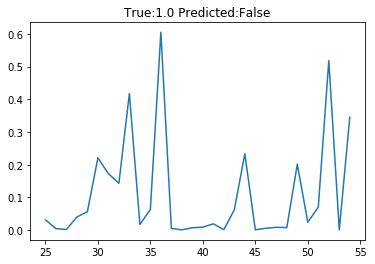

In [88]:
#import matplotlib
#import matplotlib.pyplot as plt
print(y_test)
plt.plot(np.linspace(25,54,30),model_predictions[n])
plt.title('True:'+str(y_test[n])+' Predicted:'+str(y_pred[n]))

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

In [ ]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')

  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()

plot_training(history)

In [ ]:
#Look at memory usage of all items in notebook
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)